# Modelling the close price with SARIMAX

## Imports and data

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

Load datasets

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
monthly_M2_SP = pd.read_csv(r'C:\Users\swift5\WEC2023\extended_data_monthly (2).csv')
X = pd.DataFrame(monthly_M2_SP.iloc[:,1:])
columns = monthly_M2_SP.columns
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = columns[1:])
monthly_M2_SP  = pd.concat([monthly_M2_SP.iloc[:,0], X_scaled], axis=1)
monthly_M2_SP['Date'] =  pd.to_datetime(monthly_M2_SP['Date'],  format='%Y-%m-%d')
monthly_M2_SP.set_index('Date', inplace=True)
#monthly_M2_SP.index = pd.date_range(start=monthly_M2_SP.index.min(), end=monthly_M2_SP.index.max(), freq='M')
monthly_M2_SP = monthly_M2_SP.dropna()

# Seasonality

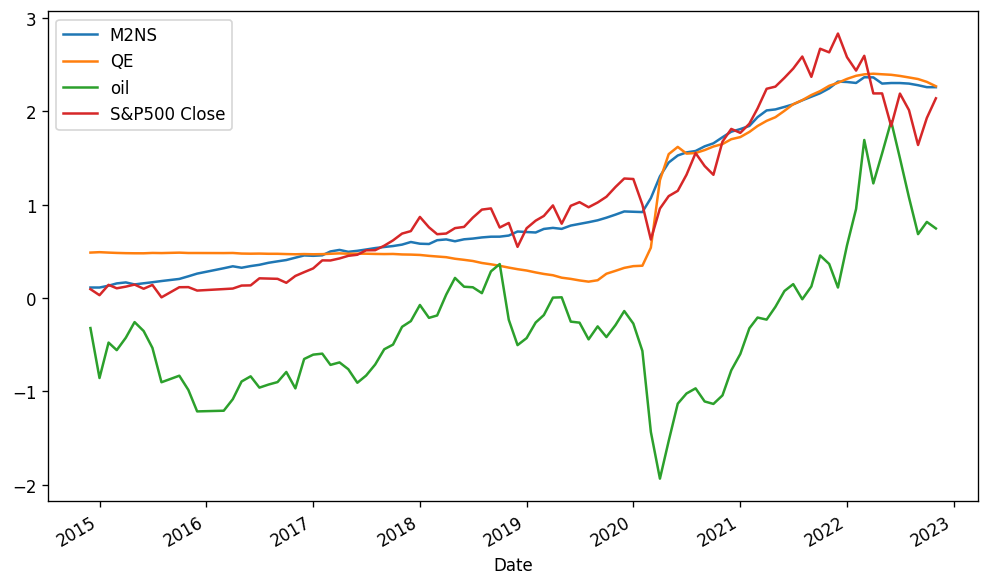

In [41]:
monthly_M2_SP['M2NS'].plot()
monthly_M2_SP['QE'].plot()
monthly_M2_SP['oil'].plot()
monthly_M2_SP['Close'].plot()

plt.legend(['M2NS','QE',"oil",'S&P500 Close'])
plt.savefig('SP_M2_std_month.png')

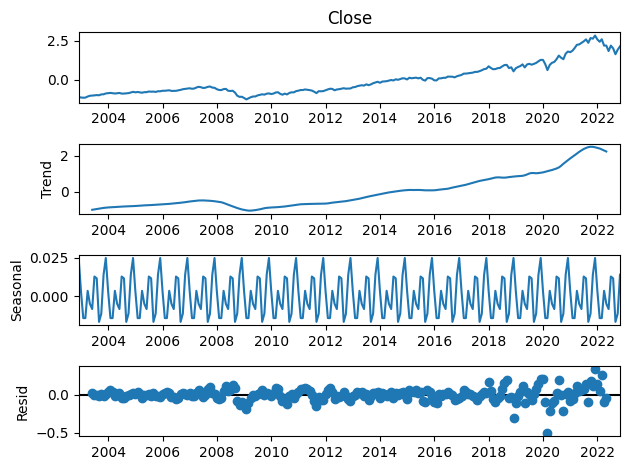

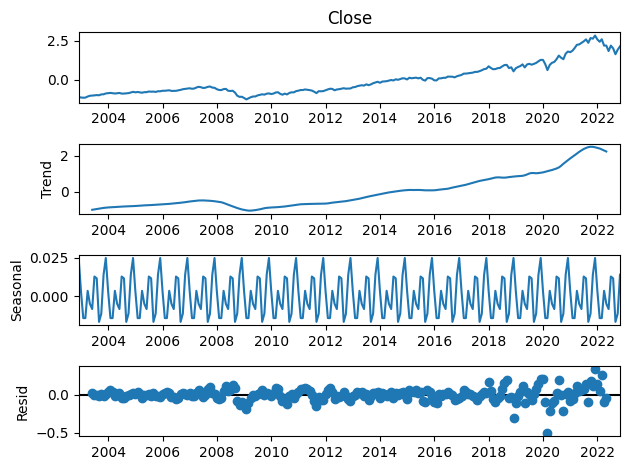

In [6]:
display(sm.tsa.seasonal_decompose(monthly_M2_SP['Close'],model='additive').plot())
plt.savefig('decomposition_month_sarimax.png')
#display(sm.tsa.seasonal_decompose(monthly_M2_SP['M2NS'],model='additive').plot())
# sm.tsa.seasonal_decompose(monthly_M2_SP['Close'],model='additive').seasonal.plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

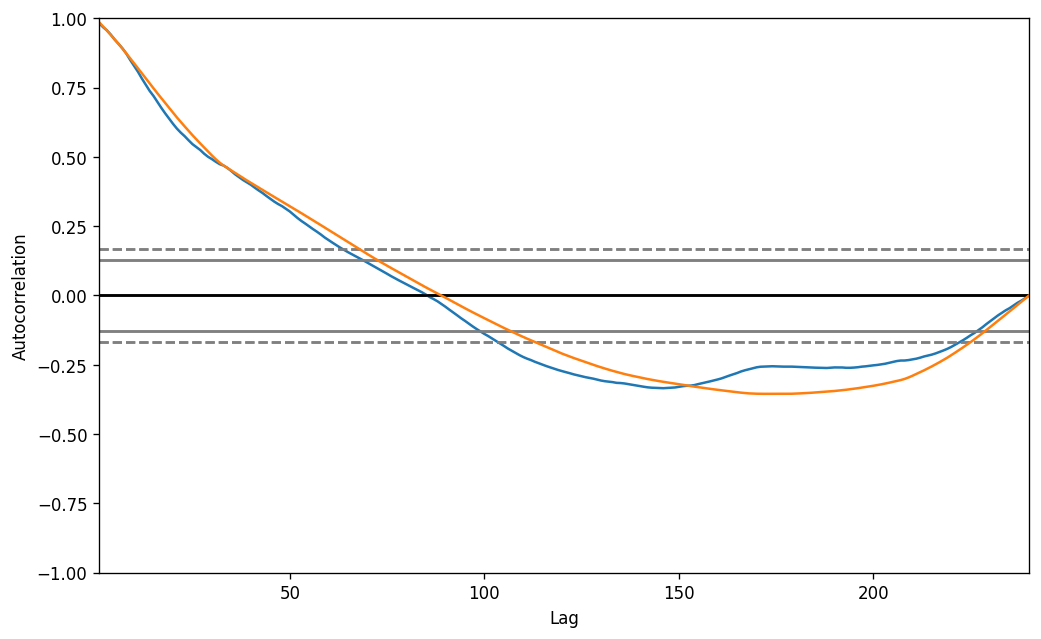

In [7]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(monthly_M2_SP['Close'].tolist())
autocorrelation_plot(monthly_M2_SP['M2NS'].tolist())
plt.savefig('SP_M2_std_month.png')


# Stationarity and test for no White Noise

## Imports

In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [9]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

## Close series

In [10]:
adf_test(monthly_M2_SP['Close'])
kpss_test(monthly_M2_SP['Close'])

adf_test(monthly_M2_SP['M2NS'])
kpss_test(monthly_M2_SP['M2NS'])

Results of Dickey-Fuller Test:
Test Statistic                   1.724409
p-value                          0.998187
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64
Results of KPSS Test:
Test Statistic            1.888751
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   0.567865
p-value                          0.986796
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64
Results of KPSS Test:
Test Statistic  

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Basic series non-stationary

### Log and diff

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


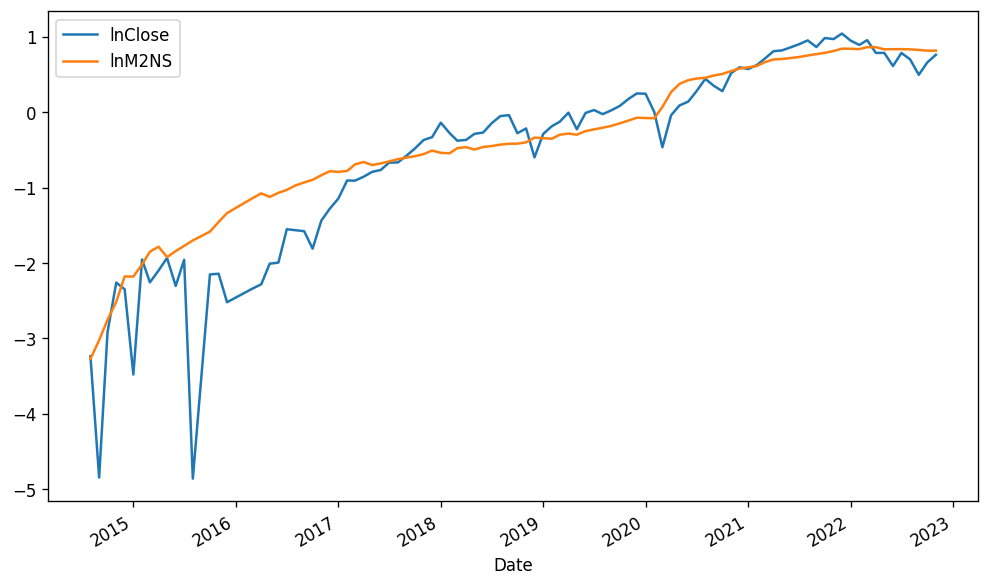

In [11]:
monthly_M2_SP['lnClose'] = np.log(monthly_M2_SP['Close'])
monthly_M2_SP.dropna(inplace=True)
monthly_M2_SP['lnM2NS'] = np.log(monthly_M2_SP['M2NS'])
monthly_M2_SP.dropna(inplace=True)
monthly_M2_SP['lnClose'].plot()
monthly_M2_SP['lnM2NS'].plot()
plt.legend(['lnClose','lnM2NS'])

In [12]:
adf_test(monthly_M2_SP['lnClose'])
kpss_test(monthly_M2_SP['lnClose'])
adf_test(monthly_M2_SP['lnM2NS'])
kpss_test(monthly_M2_SP['lnM2NS'])

Results of Dickey-Fuller Test:
Test Statistic                 -2.006723
p-value                         0.283633
#Lags Used                     11.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64
Results of KPSS Test:
Test Statistic           1.573303
p-value                  0.010000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -0.937746
p-value                         0.775288
#Lags Used                     12.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64
Results of KPSS Test:
Test Statistic           1.618175
p-v

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Both tests show non-stationarity

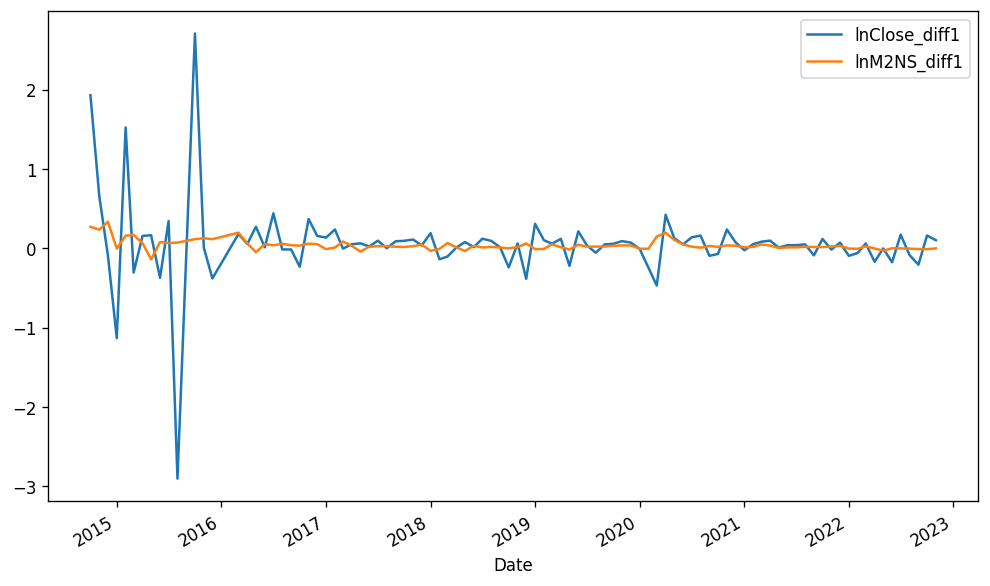

In [13]:
monthly_M2_SP['lnClose_diff1'] = monthly_M2_SP['lnClose']- monthly_M2_SP['lnClose'].shift(1)
monthly_M2_SP.dropna(inplace=True)
monthly_M2_SP['lnM2NS_diff1'] = monthly_M2_SP['lnM2NS']- monthly_M2_SP['lnM2NS'].shift(1)
monthly_M2_SP.dropna(inplace=True)
monthly_M2_SP['lnClose_diff1'].plot()
monthly_M2_SP['lnM2NS_diff1'].plot()
plt.legend(['lnClose_diff1','lnM2NS_diff1'])

In [14]:
adf_test(monthly_M2_SP['lnClose_diff1'])
kpss_test(monthly_M2_SP['lnClose_diff1'])
adf_test(monthly_M2_SP['lnM2NS_diff1'])
kpss_test(monthly_M2_SP['lnM2NS_diff1'])

Results of Dickey-Fuller Test:
Test Statistic                -1.200197e+01
p-value                        3.330370e-22
#Lags Used                     1.000000e+00
Number of Observations Used    9.300000e+01
Critical Value (1%)           -3.502705e+00
Critical Value (5%)           -2.893158e+00
Critical Value (10%)          -2.583637e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.406638
p-value                   0.074294
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -1.948216
p-value                         0.309730
#Lags Used                     11.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64
Results of KPSS Test:
Test Stat

Both tests show stationarity

### Diff once

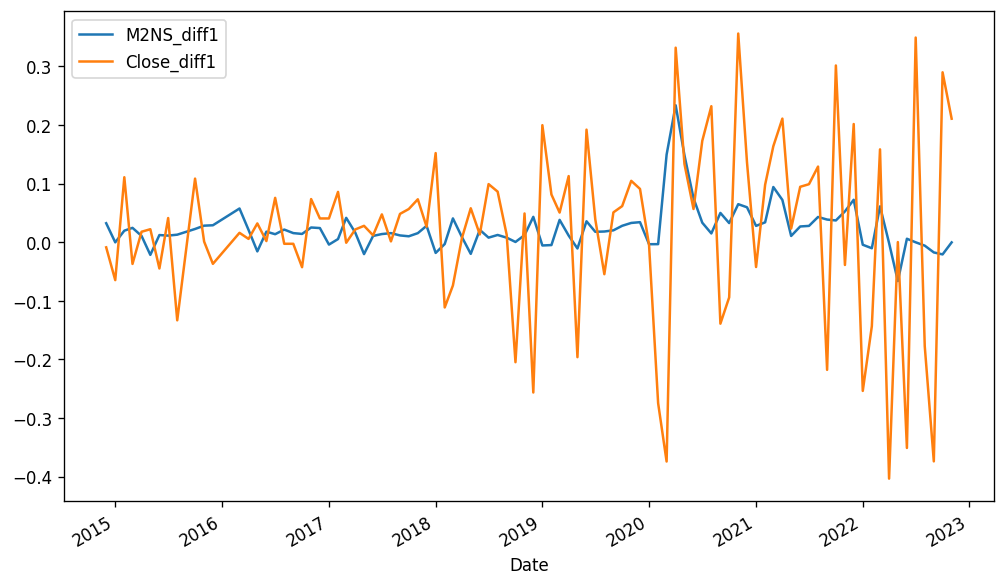

In [15]:
monthly_M2_SP['Close_diff1'] = monthly_M2_SP['Close']- monthly_M2_SP['Close'].shift(1)
monthly_M2_SP.dropna(inplace=True)
monthly_M2_SP['M2NS_diff1'] = monthly_M2_SP['M2NS']- monthly_M2_SP['M2NS'].shift(1)
monthly_M2_SP.dropna(inplace=True)
monthly_M2_SP['M2NS_diff1'].plot()
monthly_M2_SP['Close_diff1'].plot()
plt.legend(['M2NS_diff1','Close_diff1'])
plt.savefig('diff1_month_sarimax.png')

In [16]:
adf_test(monthly_M2_SP['Close_diff1'])
kpss_test(monthly_M2_SP['Close_diff1'])
adf_test(monthly_M2_SP['M2NS_diff1'])
kpss_test(monthly_M2_SP['M2NS_diff1'])

Results of Dickey-Fuller Test:
Test Statistic                 -2.766846
p-value                         0.063168
#Lags Used                      6.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64
Results of KPSS Test:
Test Statistic           0.077375
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -1.935229
p-value                         0.315674
#Lags Used                     12.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64
Results of KPSS Test:
Test Statistic           0.268478
p-v

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### White noise test Ljung-Box

In [17]:
sm.stats.acorr_ljungbox(monthly_M2_SP['lnClose_diff1'], lags=range(1,12), return_df=True)

,lb_stat,lb_pvalue
1,26.308364,2.910255e-07
2,26.684817,1.604965e-06
3,26.690100,6.837167e-06
4,27.081087,1.914244e-05
5,28.770150,2.572341e-05
6,37.637645,1.322267e-06
7,55.124907,1.408314e-09
8,58.400693,9.589430e-10
9,58.599400,2.493594e-09
10,58.605076,6.648620e-09


Base series non-stationary

# SARIMAX

In [18]:
#splitting the data to train and test sets (test for 12 weeks)
train = monthly_M2_SP.iloc[:-12]
test = monthly_M2_SP.iloc[-12:]

## Choosing p and q

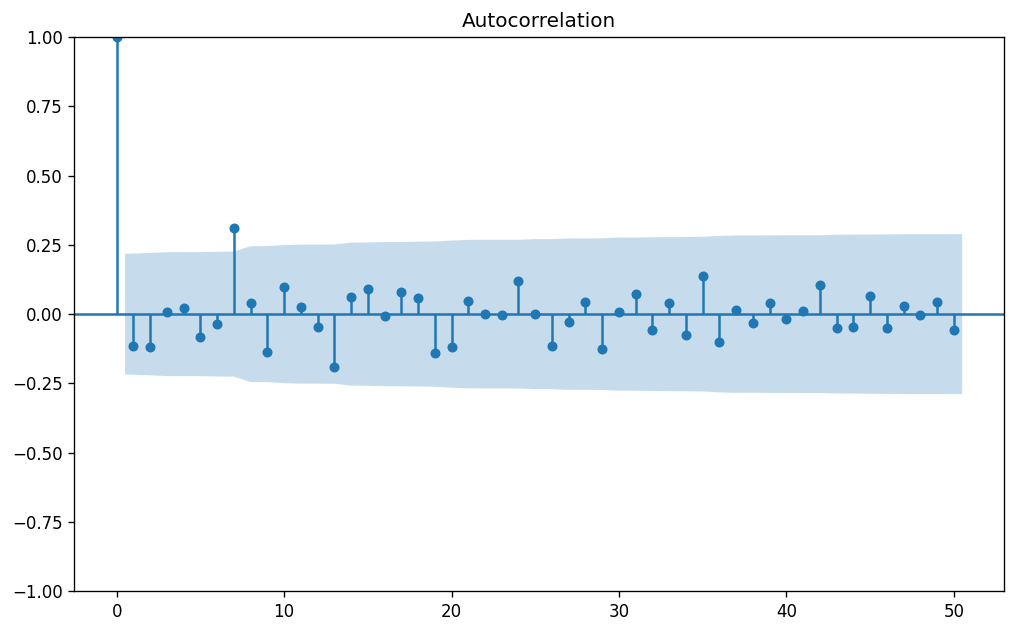

In [19]:
sm.graphics.tsa.plot_acf(train["Close_diff1"].values.squeeze(), lags=50)
plt.savefig('autocorr_month_sarimax.png')
#sm.graphics.tsa.plot_pacf(train["M2NS_diff1"].values.squeeze(), lags=50, method="ywm")

Box-Jenkins p=2 q=3

## Model choice

In [20]:
import itertools

In [21]:

p = range(0,3)
q = range(0,2)
# for already differentiated series
d = [0]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (1, 0, 0, 12)
SARIMAX: (1, 0, 0) x (1, 0, 1, 12)
SARIMAX: (1, 0, 0) x (2, 0, 0, 12)


In [22]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=train['Close'],
                                            exog =train[['M2NS', 'oil']],\
                                            trend='n',\
                                            order=param,\
                                            seasonal_order=param_seasonal)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-105.01582792351523
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-103.62200944877821


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-104.01207048746683


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-112.16541684288799
SARIMAX(0, 0, 0)x(2, 0, 0, 12)12 - AIC:-120.41868933149703


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(2, 0, 1, 12)12 - AIC:-123.10030679269559
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-127.21513667556499


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-125.26341896436207


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-125.2939337102045


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-131.54504077783858


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(2, 0, 0, 12)12 - AIC:-134.8581942583486


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

SARIMAX(0, 0, 1)x(2, 0, 1, 12)12 - AIC:-140.7363791852601
SARIMAX(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-138.83843747133776
SARIMAX(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-136.84735327039536


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-136.85266493907295


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

SARIMAX(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-140.44712842971725
SARIMAX(1, 0, 0)x(2, 0, 0, 12)12 - AIC:-144.15503980948165


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(2, 0, 1, 12)12 - AIC:-148.22619978089767


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-140.21703364999559


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-138.21842688227804


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-138.21930572865912


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

SARIMAX(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-141.57325932997222
SARIMAX(1, 0, 1)x(2, 0, 0, 12)12 - AIC:-146.34664175465136


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

SARIMAX(1, 0, 1)x(2, 0, 1, 12)12 - AIC:-149.20487306666064
SARIMAX(2, 0, 0)x(0, 0, 0, 12)12 - AIC:-138.96497960196047


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 0)x(0, 0, 1, 12)12 - AIC:-136.97052166438093


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 0)x(1, 0, 0, 12)12 - AIC:-136.973884558903


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

SARIMAX(2, 0, 0)x(1, 0, 1, 12)12 - AIC:-140.1940742751575
SARIMAX(2, 0, 0)x(2, 0, 0, 12)12 - AIC:-144.6755618729881


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

SARIMAX(2, 0, 0)x(2, 0, 1, 12)12 - AIC:-147.58841859804917


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary st

SARIMAX(2, 0, 1)x(0, 0, 0, 12)12 - AIC:-134.6316050180461


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary st

SARIMAX(2, 0, 1)x(0, 0, 1, 12)12 - AIC:-69.50563550064618


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary st

SARIMAX(2, 0, 1)x(1, 0, 0, 12)12 - AIC:-120.1046299008039


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary st

SARIMAX(2, 0, 1)x(1, 0, 1, 12)12 - AIC:-134.06720196112994


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary st

SARIMAX(2, 0, 1)x(2, 0, 0, 12)12 - AIC:-105.24310578180014
SARIMAX(2, 0, 1)x(2, 0, 1, 12)12 - AIC:-58.07552240271805


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
train.columns

Index(['CPI', 'E INFL', 'GDP growth', 'retail food services', 'PPI',
       'Risk Premium', 'QE', 'Real interest rate', 'unemployment', 'oil',
       'Open', 'High', 'Low', 'Close', 'Volume', 'M2NS', 'lnClose', 'lnM2NS',
       'lnClose_diff1', 'lnM2NS_diff1', 'Close_diff1', 'M2NS_diff1'],
      dtype='object')

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


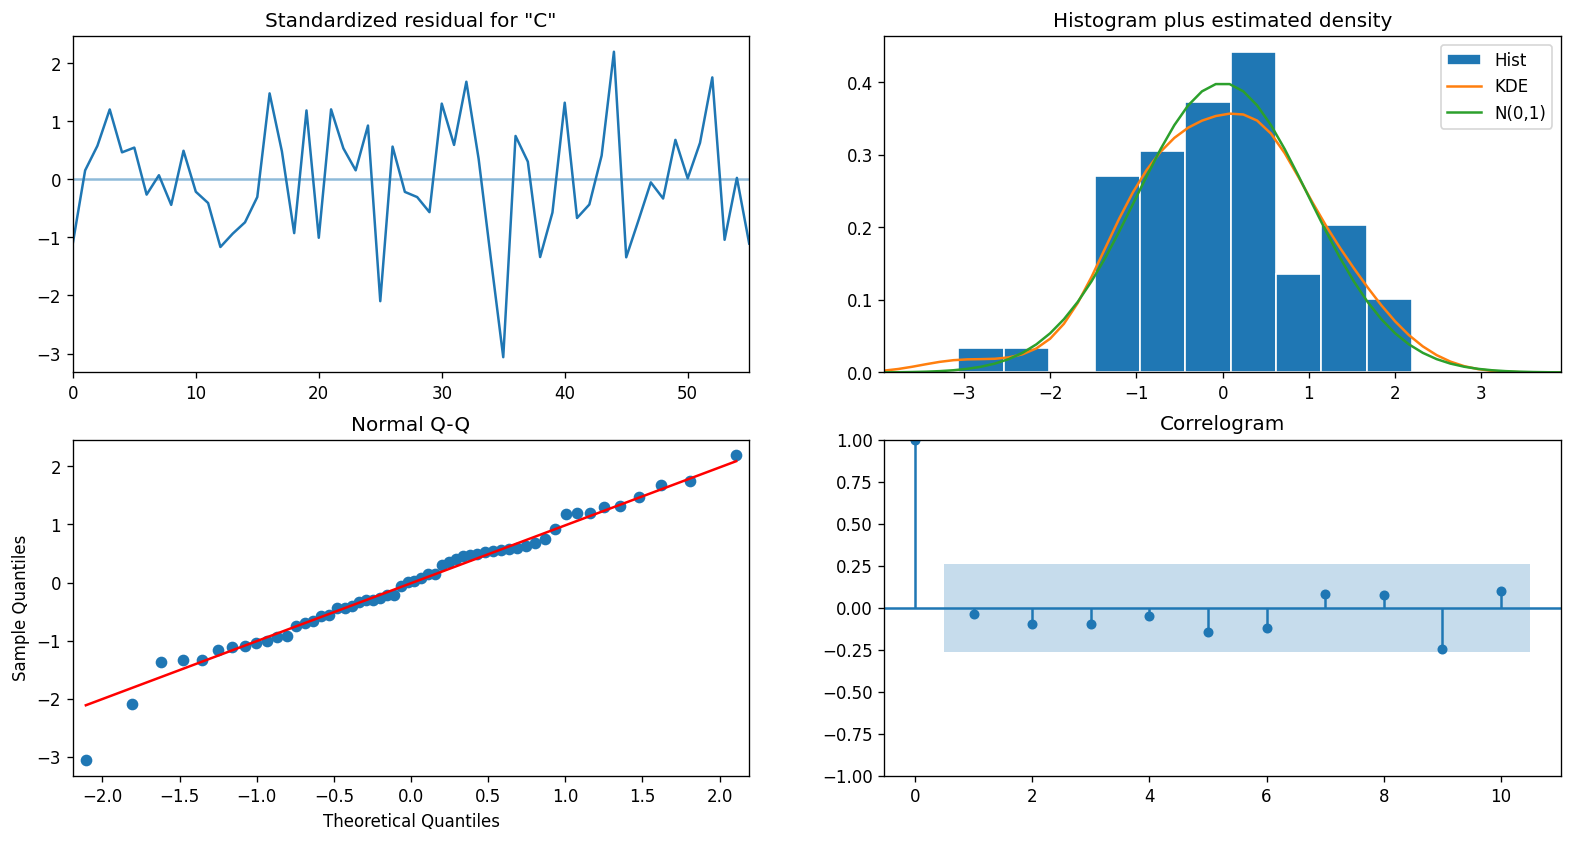

<Figure size 1200x720 with 0 Axes>

In [30]:
#lowest AIC: SARIMAX(1, 0, 1)x(2, 0, 1, 12)12 - AIC:-149.20487306666064

mod = sm.tsa.statespace.SARIMAX(endog=train['Close'],
                                exog =train[['M2NS','QE','CPI', 'E INFL', 'GDP growth', 'retail food services', 'PPI','Risk Premium','Real interest rate', 'unemployment', 'oil']],\
                                order=(1, 0, 1),
                                seasonal_order=(2, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

results.plot_diagnostics(figsize=(16, 8))
plt.show()
plt.savefig('diagnostic_month_extended_sarimax.png')

In [31]:
len(train.dropna())

81

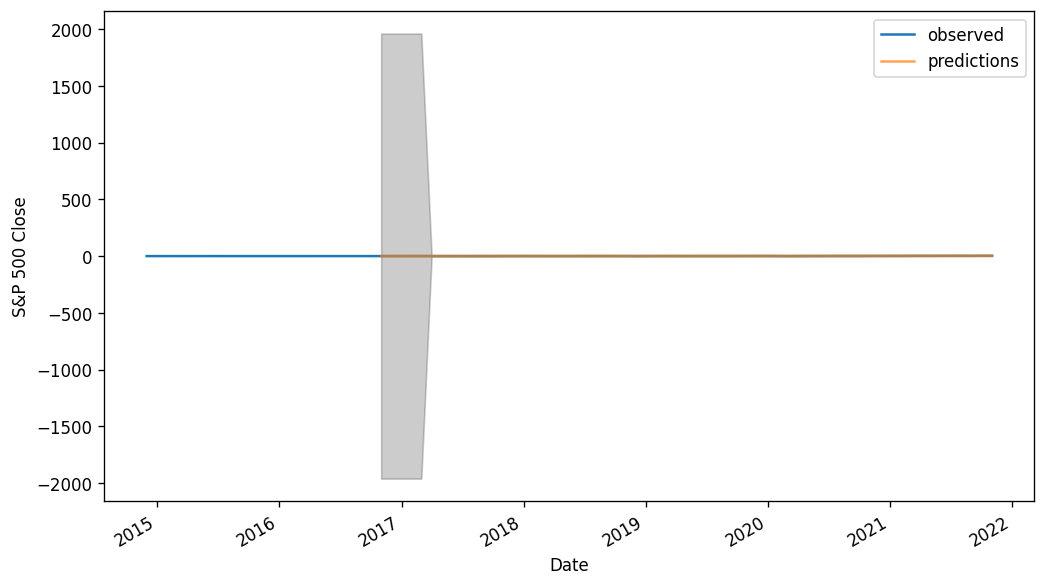

In [32]:
start_forecast = 20
pred = results.get_prediction(start=start_forecast, exog=train[['M2NS','QE','CPI', 'E INFL', 'GDP growth', 'retail food services', 'PPI','Risk Premium','Real interest rate', 'unemployment', 'oil']])
pred_ci = pred.conf_int()

ax = train['Close'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='predictions', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('S&P 500 Close')
plt.legend()
plt.savefig('forecast_month_in_sarimax.png')
plt.show()

In [33]:
pred_uc = results.get_forecast(steps=12, exog=test[['M2NS','QE','CPI', 'E INFL', 'GDP growth', 'retail food services', 'PPI','Risk Premium','Real interest rate', 'unemployment', 'oil']]) #12 weeks

idx = pd.DataFrame({'Date': ['2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01']})
pred = pd.DataFrame(pred_uc.predicted_mean)
pred = pred.reset_index()
prediction = pd.concat([idx,pred], axis = 1)
prediction = prediction.set_index(prediction["Date"])
prediction = prediction.drop(['Date', 'index'], axis=1)
prediction

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,predicted_mean
Date,
2021-12-01,2.732656
2022-01-01,2.827021
2022-02-01,2.748397
2022-03-01,2.935297
2022-04-01,2.887924
2022-05-01,2.880257
2022-06-01,2.903305
2022-07-01,2.865007
2022-08-01,2.894747


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


    lower Close  upper Close
81     2.589003     2.876309
82     2.681969     2.972073
83     2.602824     2.893970
84     2.789674     3.080919
85     2.742297     3.033552
86     2.734628     3.025887
87     2.757675     3.048935
88     2.719376     3.010637
89     2.749117     3.040378
90     2.284757     2.576019
91     2.234499     2.525760
92     2.334556     2.625817


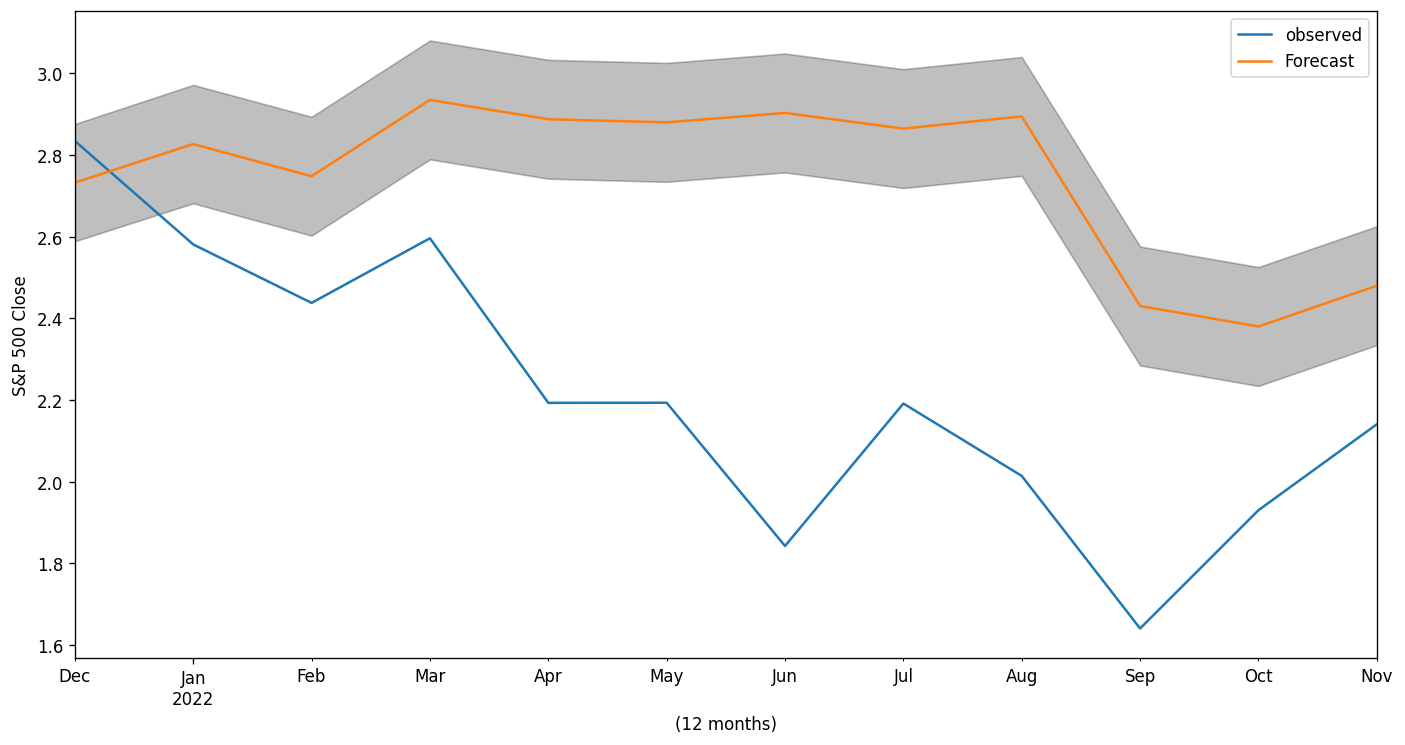

In [35]:
#%% Forecast 1y
import os

pred_uc = results.get_forecast(steps=12, exog=test[['M2NS','QE','CPI', 'E INFL', 'GDP growth', 'retail food services', 'PPI','Risk Premium','Real interest rate', 'unemployment', 'oil']]) #12 weeks
idx = pd.DataFrame({'Date': ['2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01']})
pred = pd.DataFrame(pred_uc.predicted_mean)
pred = pred.reset_index()
prediction = pd.concat([idx,pred], axis = 1)
prediction['Date'] =  pd.to_datetime(prediction['Date'],  format='%Y-%m-%d')
prediction = prediction.set_index(prediction["Date"])
prediction = prediction.drop(['Date', 'index'], axis=1)

pred_ci = pred_uc.conf_int()
pred_c = pd.DataFrame(pred_uc.conf_int())
pred_c = pred_c.reset_index()
pred_c = pd.concat([idx,pred_c], axis = 1)
pred_c['Date'] =  pd.to_datetime(pred_c['Date'],  format='%Y-%m-%d')
pred_c = pred_c.set_index(pred_c["Date"])
pred_c = pred_c.drop(['Date', 'index'], axis=1)

ax = test['Close'].plot(label='observed', figsize=(14, 7))
prediction["predicted_mean"].plot(ax=ax, label='Forecast')
print(pred_ci)
ax.fill_between(pred_c.index,
                pred_c.iloc[:, 0],
                pred_c.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('(12 months)')
ax.set_ylabel('S&P 500 Close')
plt.legend()
plt.show() 
plt.savefig('forecast_month_sarimax.png')
plt.close()


In [42]:
#!pip install scikit-learn

from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = test['Close']

y_pred = [train['Close'][-1] + prediction["predicted_mean"][0]]

for diff in prediction["predicted_mean"][1:]:
    pred_value = y_pred[-1] + diff
    y_pred.append(pred_value)

def MAPE(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

print("MAPE: ", MAPE(y_true, y_pred))
print("MSE: ", mean_squared_error(y_true, y_pred))
print("MAE: ",mean_absolute_error(y_true, y_pred))
for table in results.summary().tables:
    print('#################################################')
    print(table.as_latex_tabular())
    #print(table)

MAPE:  915.9870609406343
MSE:  446.04427116445095
MAE:  18.65962457867901
#################################################
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   &             Close              & \textbf{  No. Observations:  } &    81    \\
\textbf{Model:}           & SARIMAX(1, 0, 1)x(2, 0, 1, 12) & \textbf{  Log Likelihood     } &  63.830  \\
\textbf{Date:}            &        Sun, 23 Apr 2023        & \textbf{  AIC                } & -93.661  \\
\textbf{Time:}            &            02:42:14            & \textbf{  BIC                } & -59.230  \\
\textbf{Sample:}          &               0                & \textbf{  HQIC               } & -80.312  \\
\textbf{}                 &              - 81              & \textbf{                     } &          \\
\textbf{Covariance Type:} &              opg               & \textbf{                     } &          \\
\bottomrule
\end{tabular}
%\caption{SARIMAX Results}
\end{center}
######################